In [1]:
from collections import defaultdict

import jax

#jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import jax.random as jr  
import matplotlib.pyplot as plt
import numpy as np

# Setup

We train MLP in SP and/or μP, and observe the training dynamics wrt the learning rate η for fixed -
 
- batch size $B$ or 
- *temperature* given by $\frac{\eta}{B}$.

We also downscale the last layer by the "richness" parameter γ, which we take to be $.01, .1,  1., 10. 100.$ to observe all regimes.

In [2]:
from batch_size_studies.configs import get_main_experiment_configs, get_main_hyperparameter_grids
from batch_size_studies.data_utils import (
    filter_loss_dicts, moving_average, sample_aware_smooth_loss_dicts, extract_loss_histories, filter_loss_dict_by_cutoff, subsample_loss_dict_periodic
)

from batch_size_studies.checkpoint_utils import CheckpointManager, load_experiment_weights
from batch_size_studies.definitions import RunKey
from batch_size_studies.experiments import (
    Parameterization,
    SyntheticExperimentFixedData,
    SyntheticExperimentFixedTime,
    MNIST1MExperiment
)
from batch_size_studies.models import MLP
from batch_size_studies.plotting_utils import plot_loss_curves, plot_loss_heatmap,plot_all_loss_curves


In [3]:
MOVING_AVG_SAMPLES_WINDOW = 1000

rk_smoother = lambda rk, loss_history: moving_average(
    loss_history, 
    max(round(MOVING_AVG_SAMPLES_WINDOW / rk.batch_size), 1)
)

In [4]:
all_experiments = get_main_experiment_configs()
batch_sizes, etas = get_main_hyperparameter_grids()

print(f"There are {len(batch_sizes)} batch sizes:")
print(batch_sizes)

print(f"\n There are {len(etas)} learning rates:")
print([f"{eta:.0e}" for eta in etas])

There are 17 batch sizes:
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]

 There are 25 learning rates:
['2e-04', '5e-04', '1e-03', '2e-03', '4e-03', '8e-03', '2e-02', '3e-02', '6e-02', '1e-01', '2e-01', '5e-01', '1e+00', '2e+00', '4e+00', '8e+00', '2e+01', '3e+01', '6e+01', '1e+02', '3e+02', '5e+02', '1e+03', '2e+03', '4e+03']


In [5]:
all_temps = np.unique(np.array(etas)[:, np.newaxis] / np.array(batch_sizes))
print(f'Temperatures are in the range [2^{round(np.log2(all_temps).min())}, 2^{round(np.log2(all_temps).max())}], logarithmically spaced.')

Temperatures are in the range [2^-28, 2^12], logarithmically spaced.


# MNIST 1M

In [6]:
from batch_size_studies.runner import run_experiment_sweep


In [7]:
mnist_1m = {k:v for k,v in all_experiments.items() if isinstance(v, MNIST1MExperiment)}

The names of the experiments should follow convention of `<task>_<parameterization>_<loss_fn_type>_<gamma_value>`

In [8]:
experiments = mnist_1m
for k in experiments.keys():
    print(k)

mnist1m_classification_mup_MSE_gamma1e-05
mnist1m_classification_mup_MSE_gamma0p01
mnist1m_classification_mup_MSE_gamma0p1
mnist1m_classification_mup_MSE_gamma1p0
mnist1m_classification_mup_MSE_gamma10p0
mnist1m_classification_mup_MSE_gamma100p0
mnist1m_classification_mup_MSE_gamma100000p0


Each experiment object is a Dataclass with all relevant parameters for training dynamics specified. Let's look at one.

In [9]:
from pprint import pprint
pprint(experiments['mnist1m_classification_mup_MSE_gamma0p01'])

MNIST1MExperiment(N=128,
                  L=3,
                  parameterization=<Parameterization.MUP: 'muP'>,
                  num_epochs=1,
                  optimizer=<OptimizerType.SGD: 'SGD'>,
                  loss_type=<LossType.MSE: 'MSE'>,
                  gamma=0.01,
                  D=784,
                  num_outputs=10,
                  experiment_type='mnist1m_classification')


This script will run the experiments for all `batch_sizes` and `etas`. If the results are already available, it loads them. If not, it sends them for training and waits until results are ready. For synthetic tasks the wait times are manageable but for MNIST1m, probably better to ensure running for existing batches. Alternatively, can load only the available results via 
```
losses, failed_runs = config.load_results(directory=EXPERIMENTS_DIR)
```


In [10]:
loss_dicts = defaultdict(list)

In [11]:
for exp_name, e in experiments.items():
    results_obj, _ = run_experiment_sweep(e, batch_sizes, etas) # second is failed_runs, which is the set of RunKeys (batch, eta) that have diverged in prior experiments ran
    loss_dicts[exp_name] = results_obj

Hyperparameter Sweep:   0%|          | 0/425 [00:00<?, ?it/s]

Hyperparameter Sweep:   0%|          | 0/425 [00:00<?, ?it/s]

Hyperparameter Sweep:   0%|          | 0/425 [00:00<?, ?it/s]

Hyperparameter Sweep:   0%|          | 0/425 [00:00<?, ?it/s]

Hyperparameter Sweep:   0%|          | 0/425 [00:00<?, ?it/s]

Hyperparameter Sweep:   0%|          | 0/425 [00:00<?, ?it/s]

Hyperparameter Sweep:   0%|          | 0/425 [00:00<?, ?it/s]

The `results_obj` object, loaded from an experiment's results file, is a Python dictionary that maps each hyperparameter trial to its outcome.

*   **Keys**: The keys of the dictionary are `RunKey` objects. A `RunKey` is a lightweight object that uniquely identifies a single training run by its core hyperparameters, which are `batch_size` and `eta` (learning rate).
    *   *Example*: `RunKey(batch_size=64, eta=0.01)`

*   **Values**: The values are dictionaries containing the metrics for that specific run. Common keys in this inner dictionary include:
    *   `'loss_history'`: A list of loss values recorded during training.
    *   `'epoch_test_accuracies'`: A list of test accuracies, one for each epoch.
    *   `'final_test_accuracy'`: The final test accuracy achieved by the run.

In next iteration of the work, we would replace `eta` with object fully specifying the behavior of the appropriate optimizer (say, betas for Adam).

## Online losses in batches and in temp

To treat runs wtih different batch sizes (and hence less iterations) together, we smooth the loss curve in sample space, i.e. the window of the moving average depends on the batch size

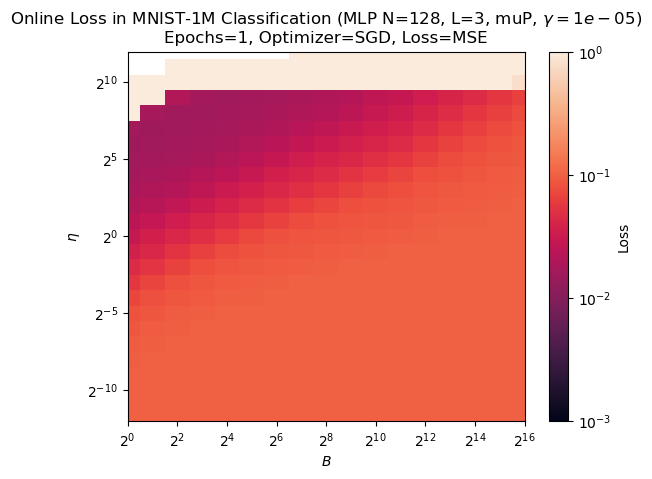

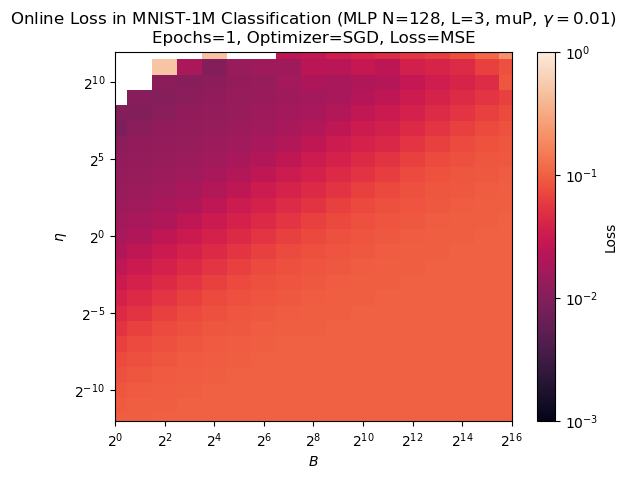

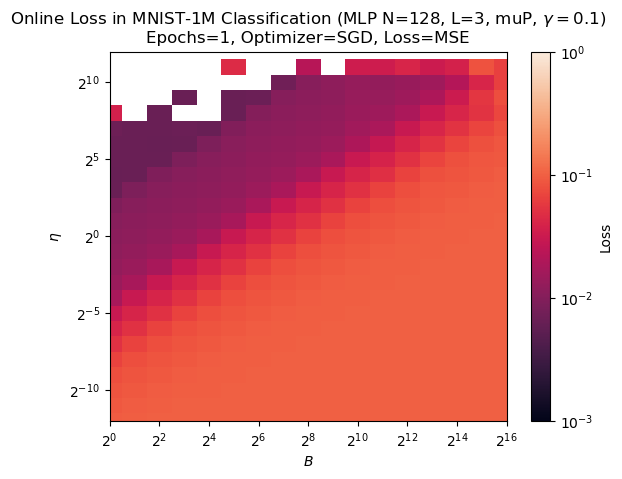

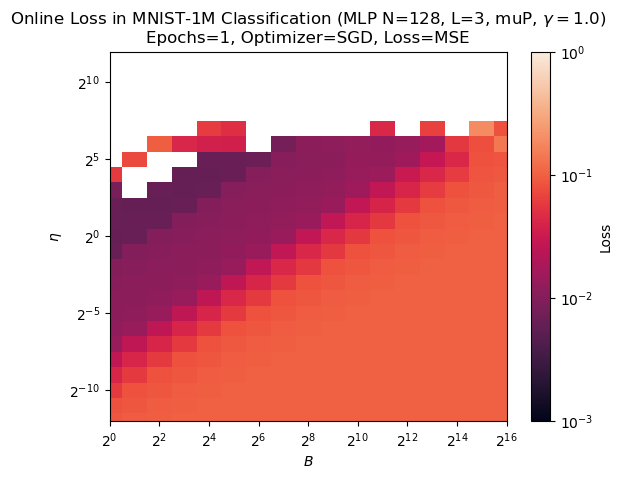

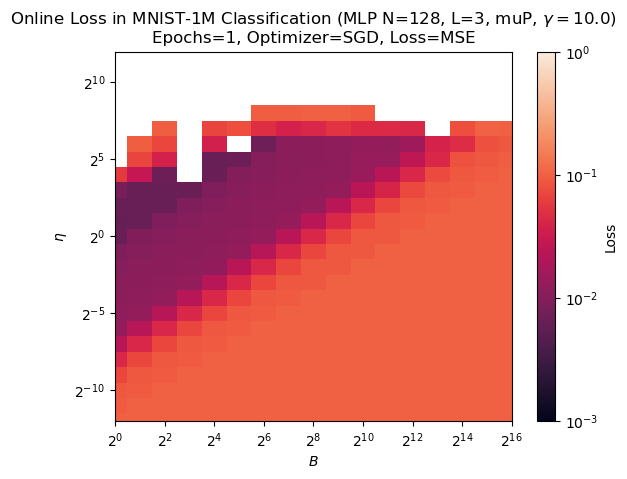

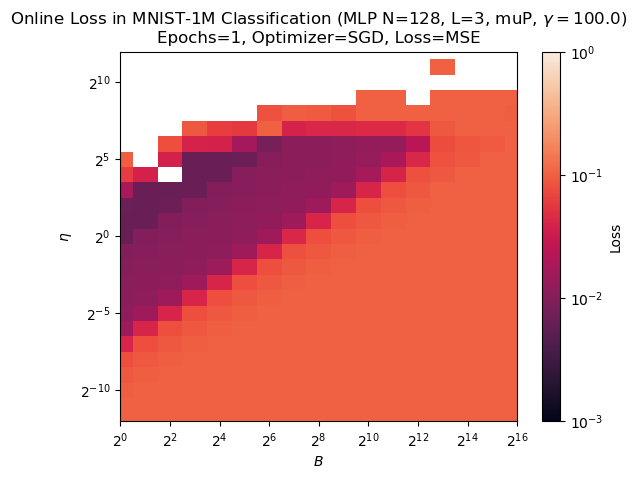

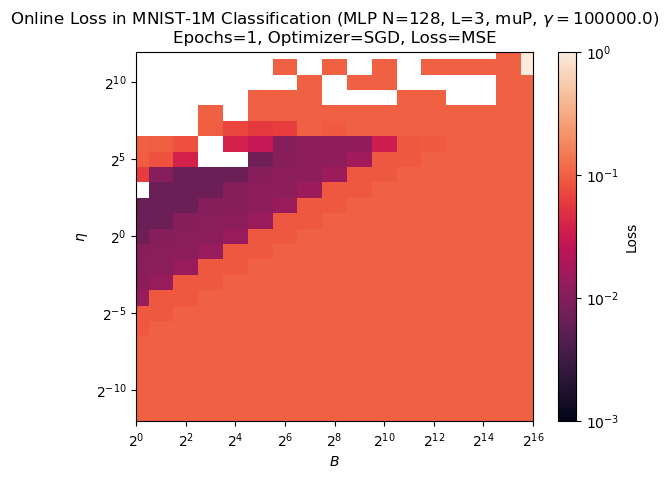

In [12]:
for exp_name, losses in loss_dicts.items():
    plot_loss_heatmap(
        sample_aware_smooth_loss_dicts(losses, rk_smoother),
        batch_sizes, etas, experiments[exp_name].plot_title(), clim=(-3,0));

To do the heatmap with temperature, i.e. $\frac{\eta}{B}$, as $x$-axis, set the flag `use_ratio_axis` to `True`.

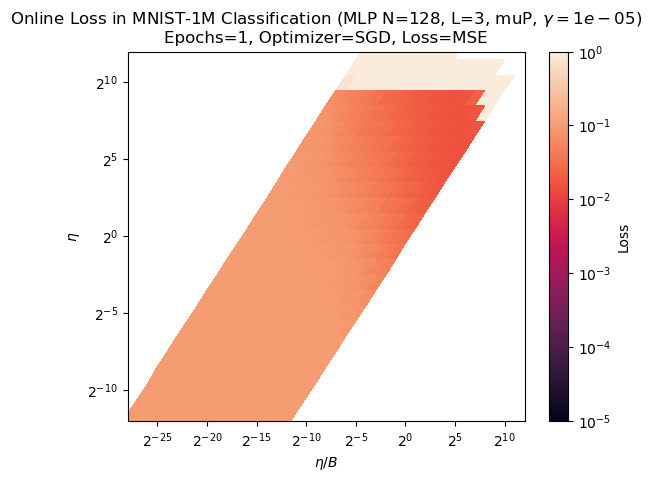

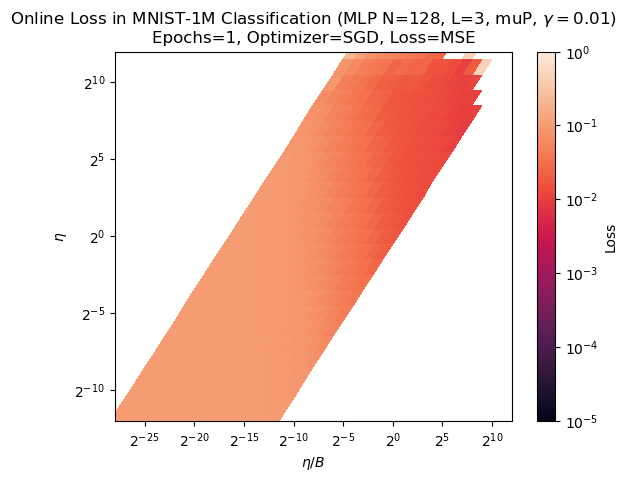

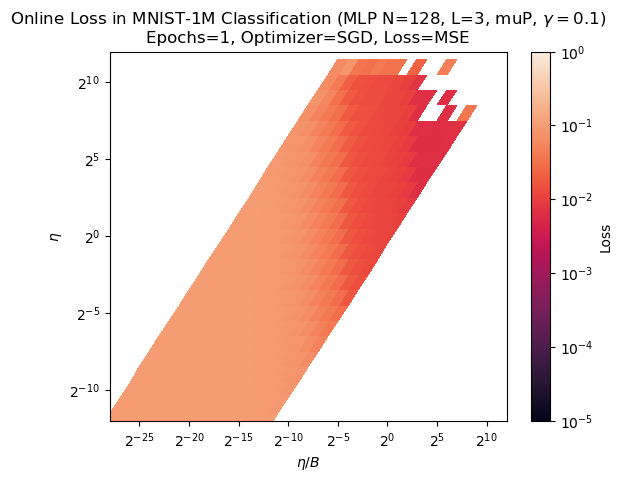

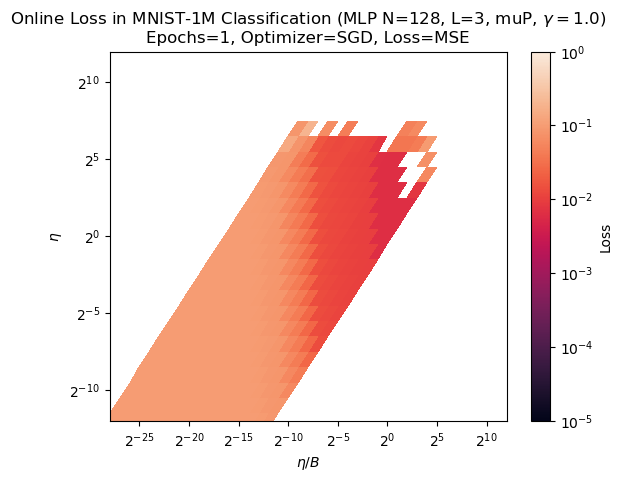

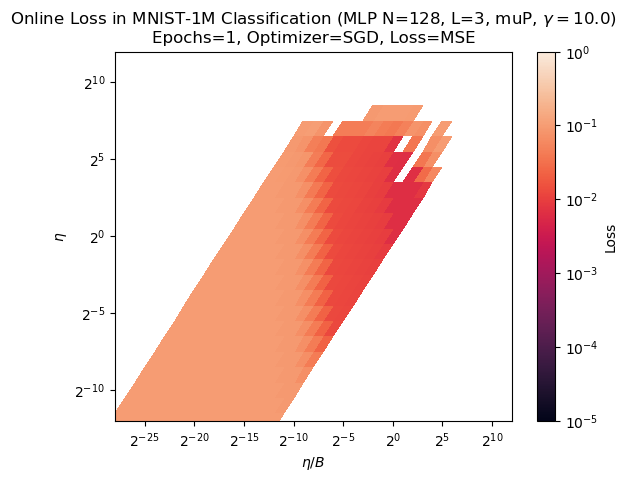

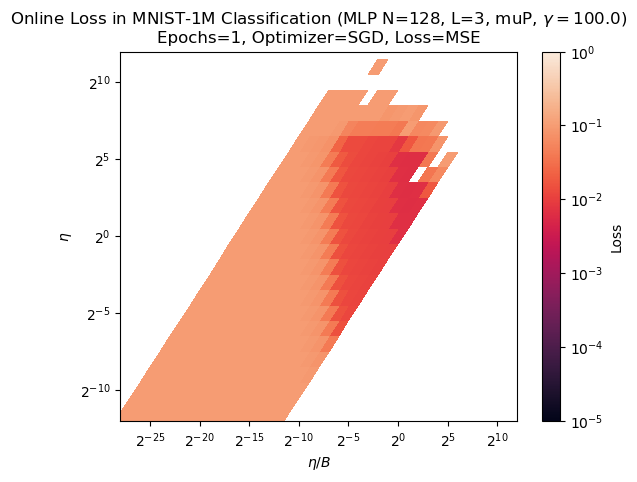

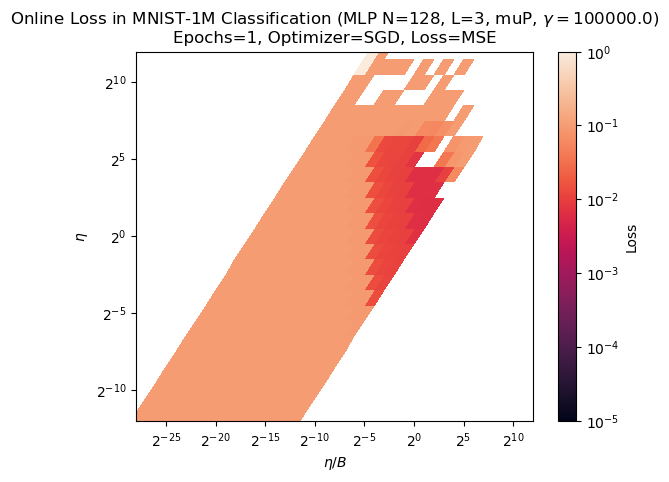

In [13]:
for exp_name, losses in loss_dicts.items():
    plot_loss_heatmap(
        sample_aware_smooth_loss_dicts(losses, rk_smoother),
        batch_sizes, etas, experiments[exp_name].plot_title(), clim=(-5,0), use_ratio_axis=True);

## Loss curves (smoothed)

To plot the loss curves, we need to specify which training runs should be plotted together. This is achieved via `group_by` with options
- `B` for batch sizes
- `eta`for learning rates
- `temp` for temperatures

If `group_values` is `None` we generate plots for all available. If `group_values` has specified value -- only for all `RunKey`s with that value in the space determined by `group_by`.

We also have choice for the $x$-axis. 
- use_eff_steps (bool): If True, x-axis is **effective steps** (steps * eta).
- use_samples_seen (bool): If True, x-axis is **samples seen** (steps * B).

In [14]:
gamma0 = 'mnist1m_classification_mup_MSE_gamma100p0'

In [15]:
all_temps

array([3.72529030e-09, 7.45058060e-09, 1.49011612e-08, 2.98023224e-08,
       5.96046448e-08, 1.19209290e-07, 2.38418579e-07, 4.76837158e-07,
       9.53674316e-07, 1.90734863e-06, 3.81469727e-06, 7.62939453e-06,
       1.52587891e-05, 3.05175781e-05, 6.10351562e-05, 1.22070312e-04,
       2.44140625e-04, 4.88281250e-04, 9.76562500e-04, 1.95312500e-03,
       3.90625000e-03, 7.81250000e-03, 1.56250000e-02, 3.12500000e-02,
       6.25000000e-02, 1.25000000e-01, 2.50000000e-01, 5.00000000e-01,
       1.00000000e+00, 2.00000000e+00, 4.00000000e+00, 8.00000000e+00,
       1.60000000e+01, 3.20000000e+01, 6.40000000e+01, 1.28000000e+02,
       2.56000000e+02, 5.12000000e+02, 1.02400000e+03, 2.04800000e+03,
       4.09600000e+03])

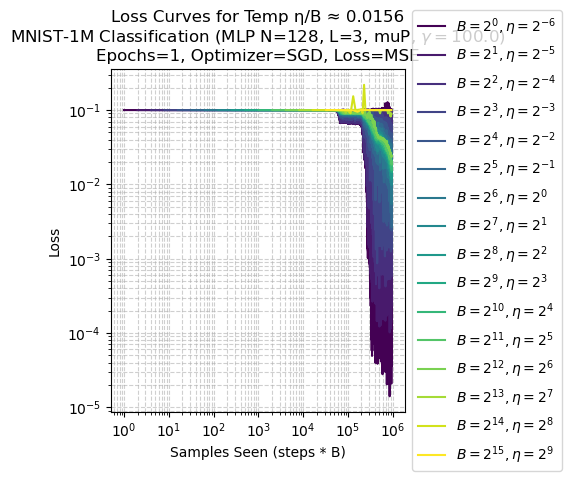

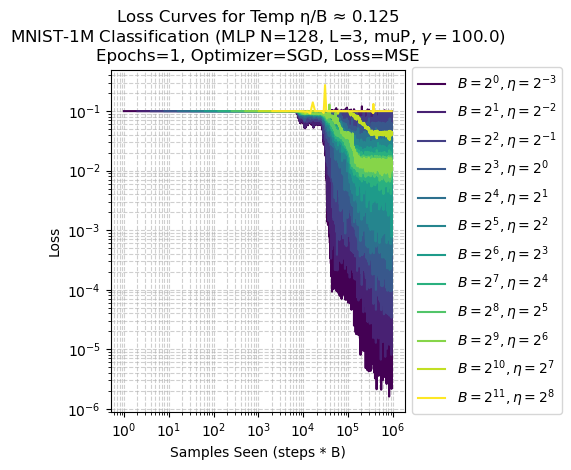

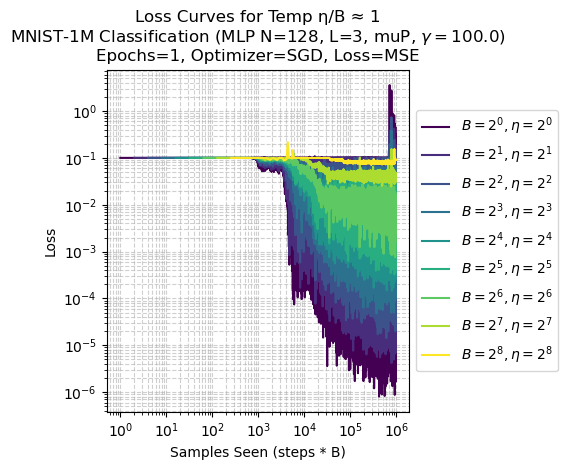

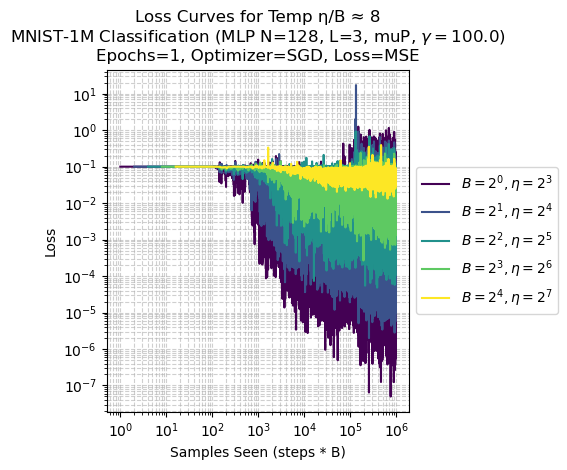

In [16]:
temps = np.power(2.0, np.arange(-6, 4, 3))
# unsmoothed
for temp in temps:
    plot_loss_curves(
        loss_dicts[gamma0],
        title_exp=experiments[gamma0].plot_title(),
        group_by="temp",
        group_values=temp,
        use_samples_seen=True,
        x_scale="log",
        cmap="viridis",
        display_now=True,
    )

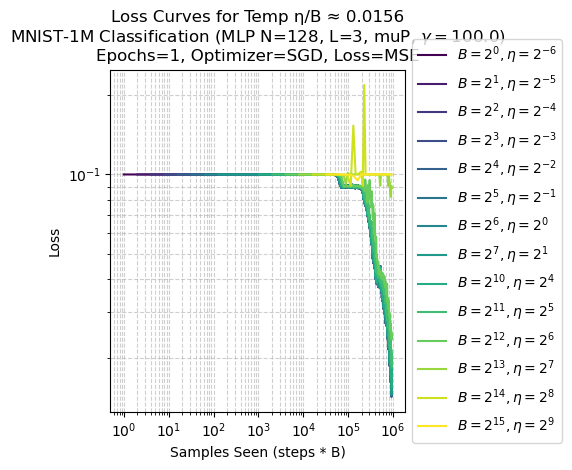

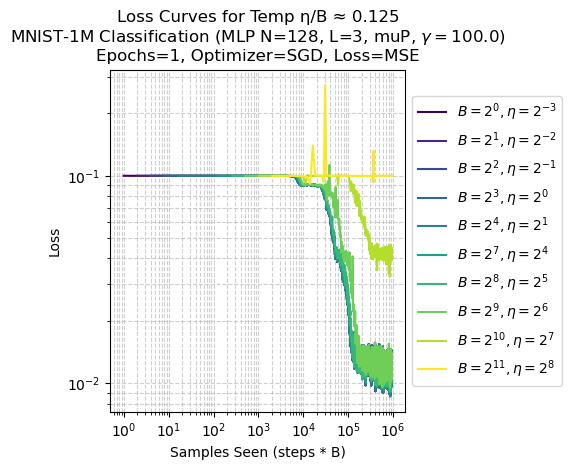

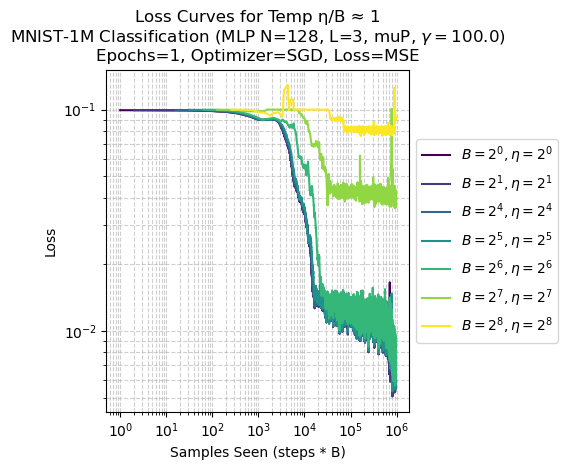

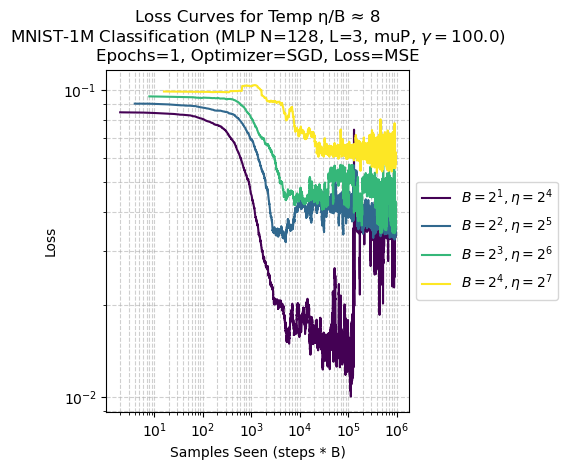

In [17]:
# smoothed
for temp in temps:
    plot_loss_curves(
        sample_aware_smooth_loss_dicts(
            filter_loss_dicts(loss_dicts[gamma0], filter_by='eta', values=[4, 8], keep=False),
            rk_smoother
        ),
        title_exp=experiments[gamma0].plot_title(),
        group_by="temp",
        group_values=temp,
        use_samples_seen=True,
        x_scale="log",
        cmap="viridis",
        display_now=True,
    )   

## All losses at once

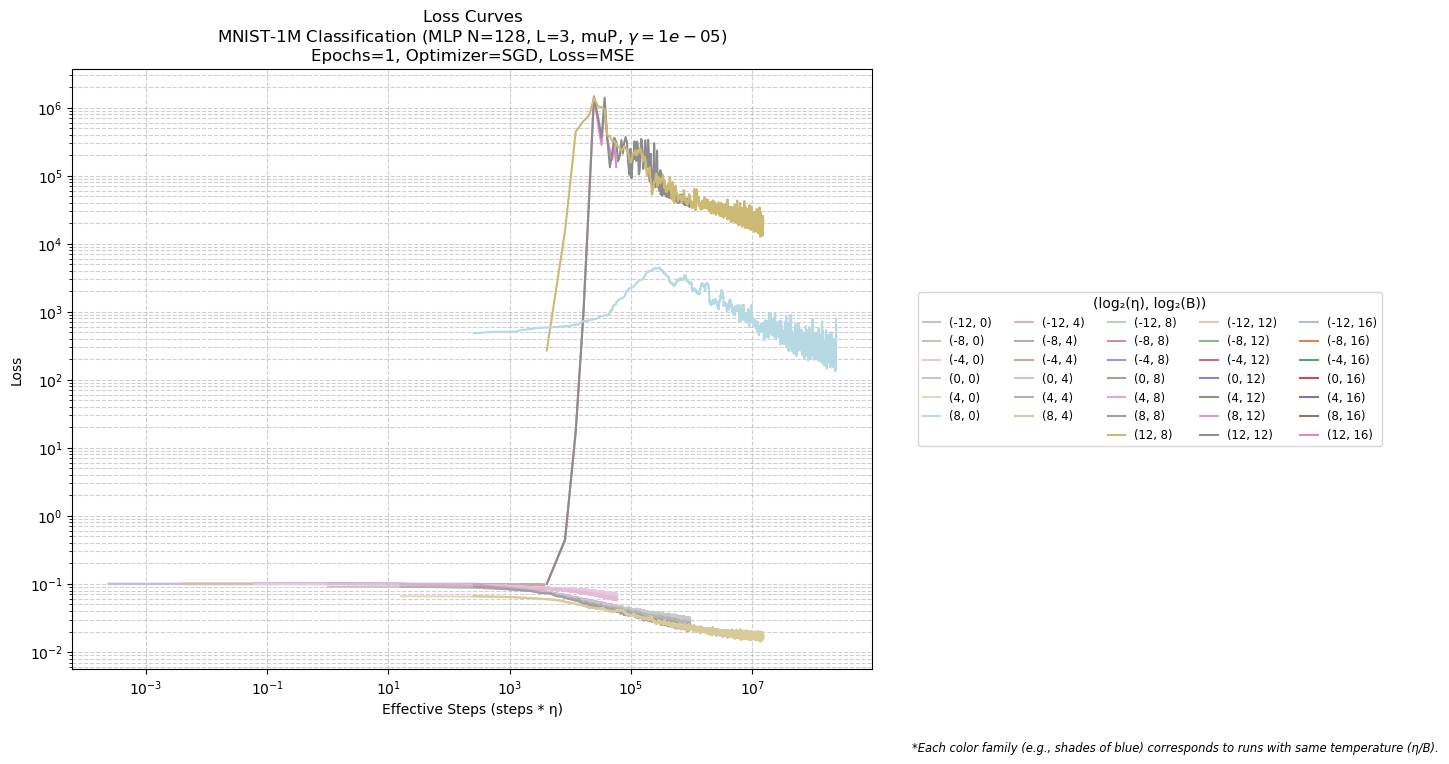

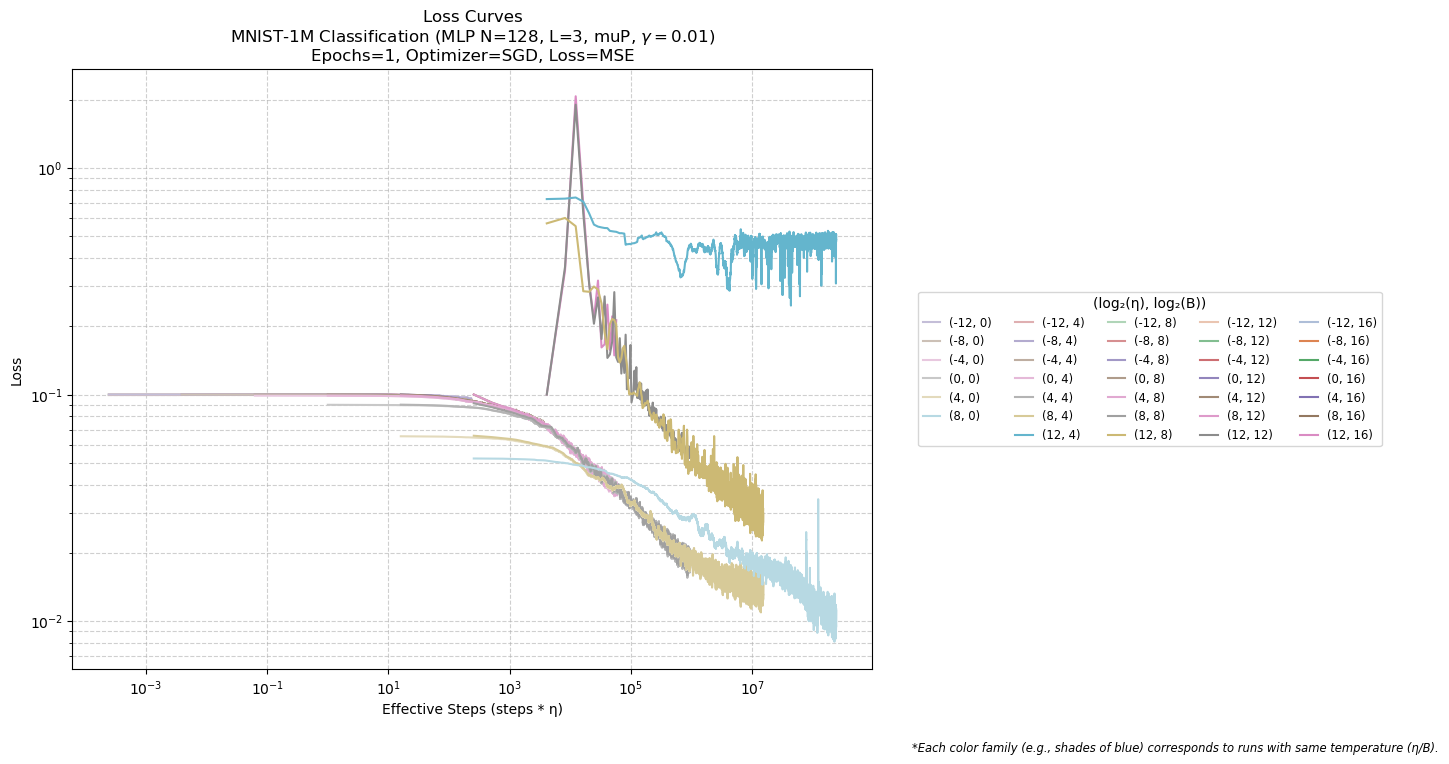

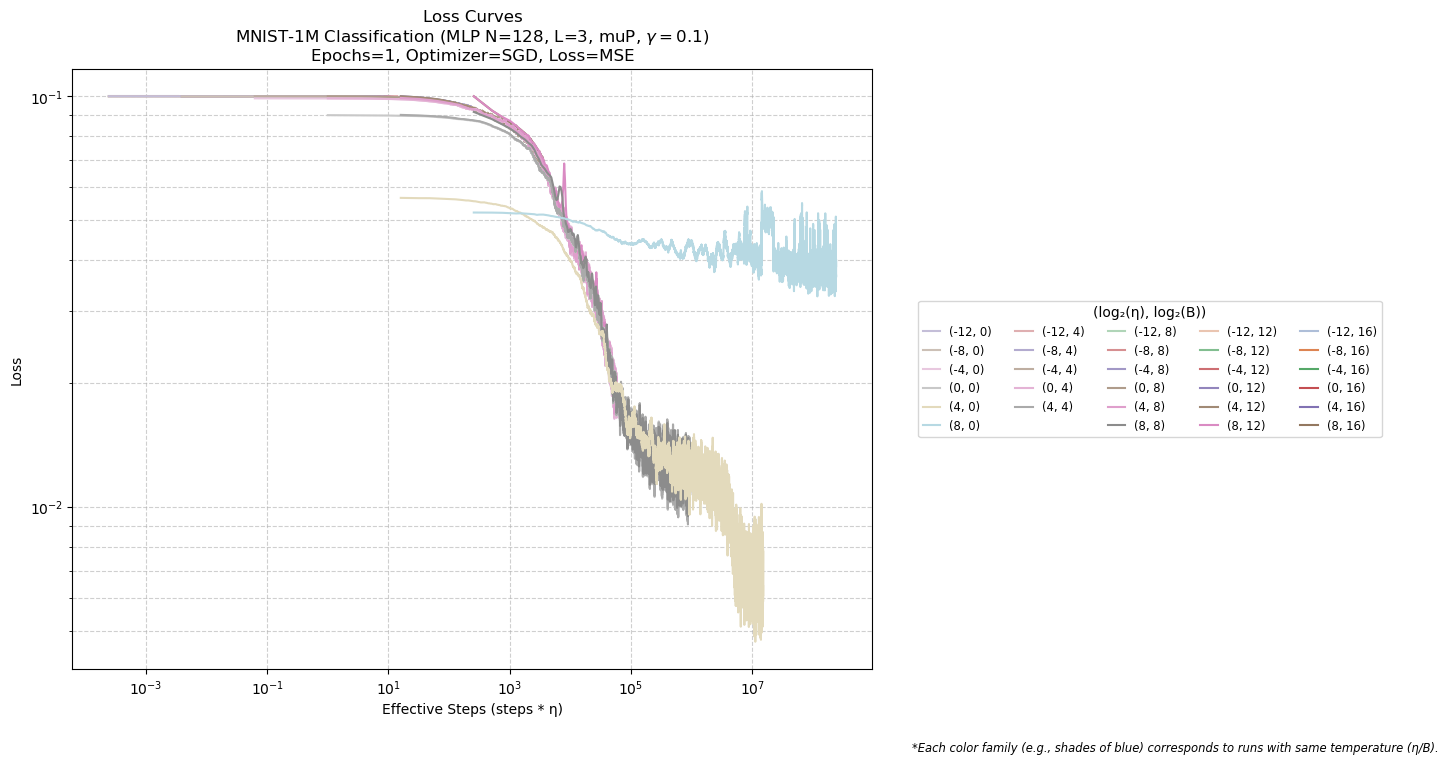

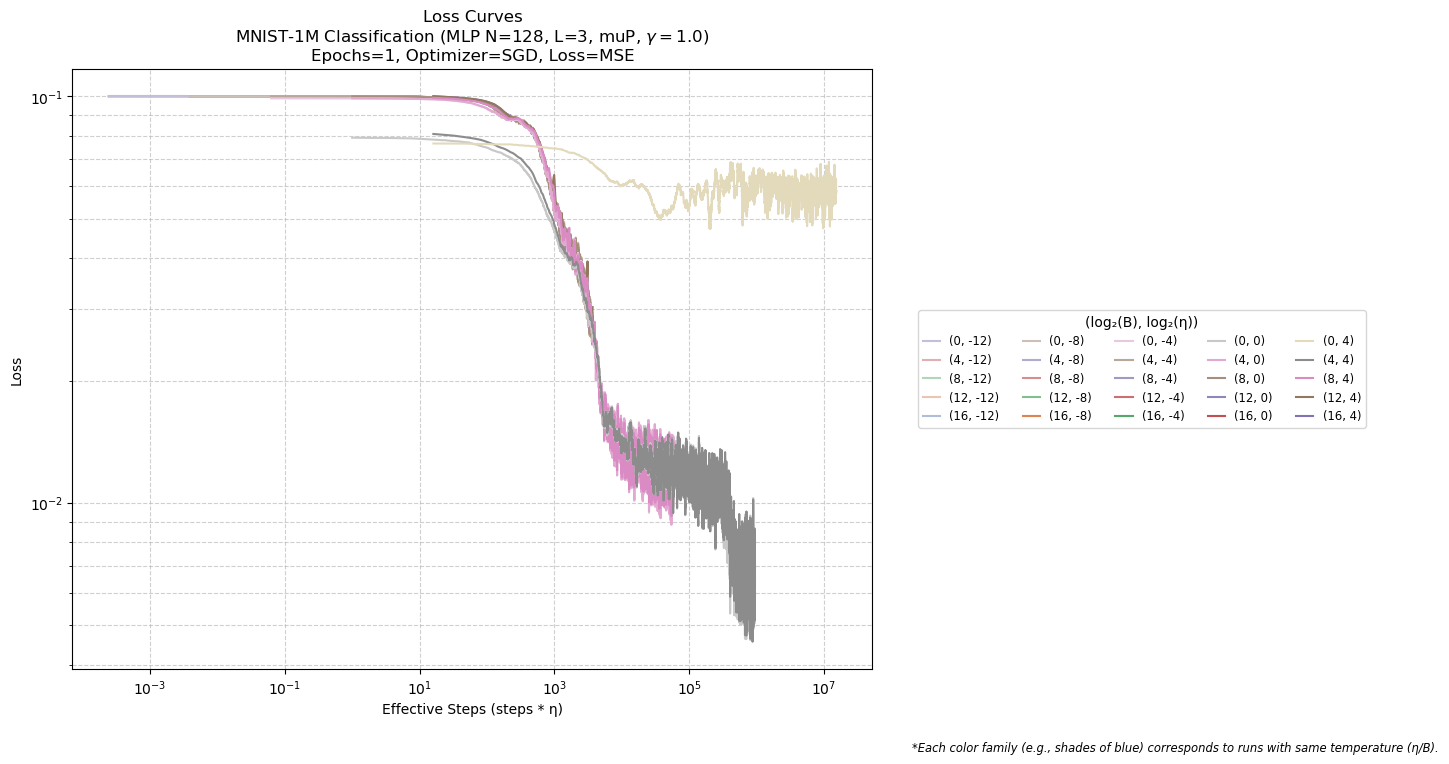

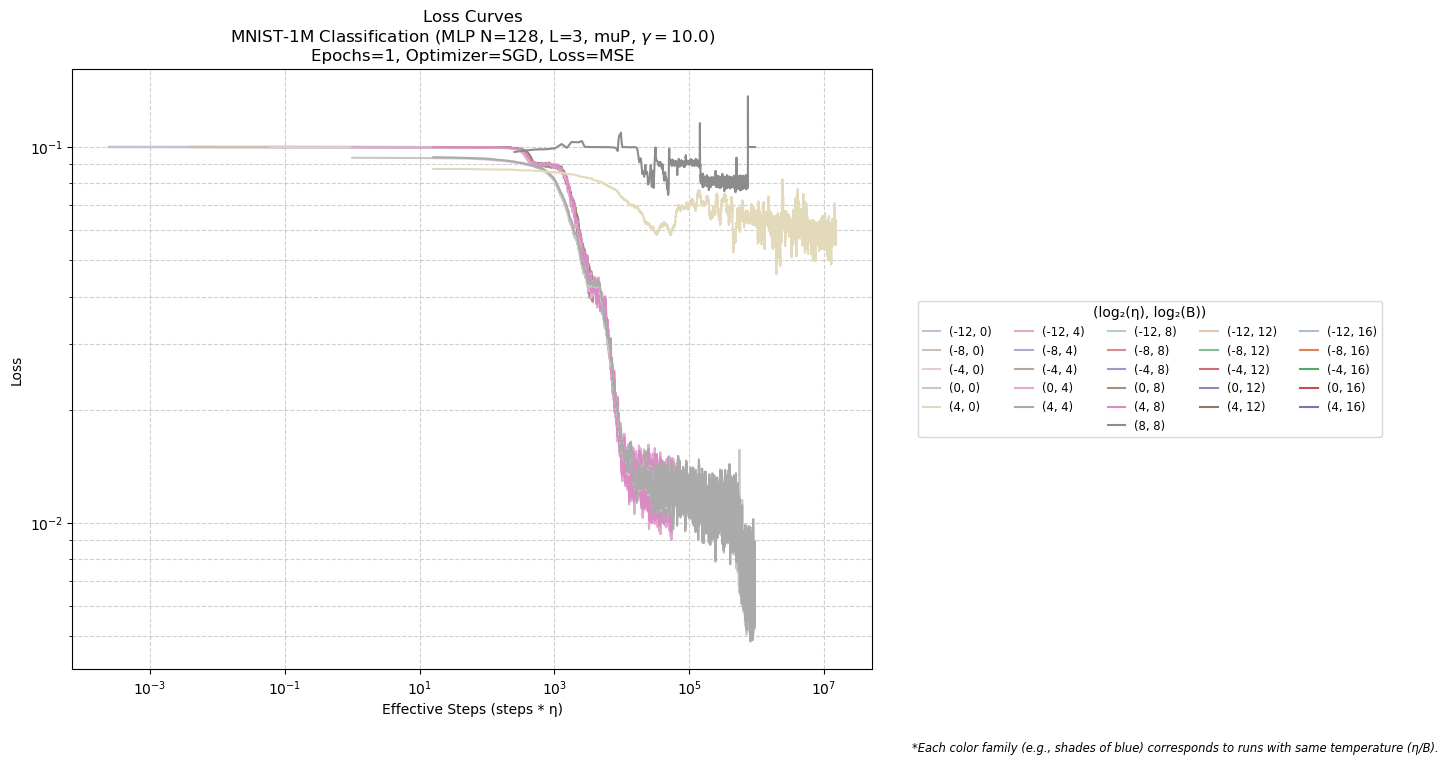

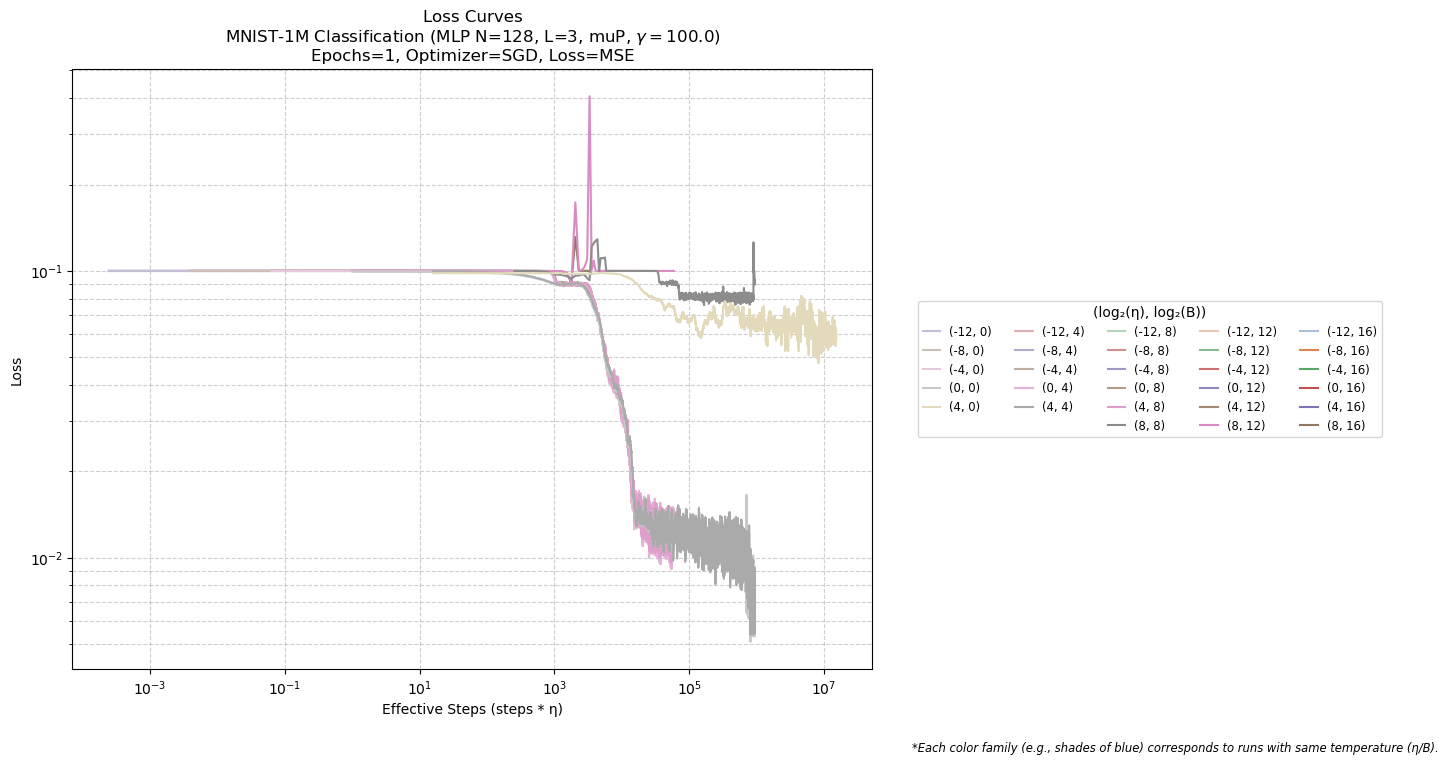

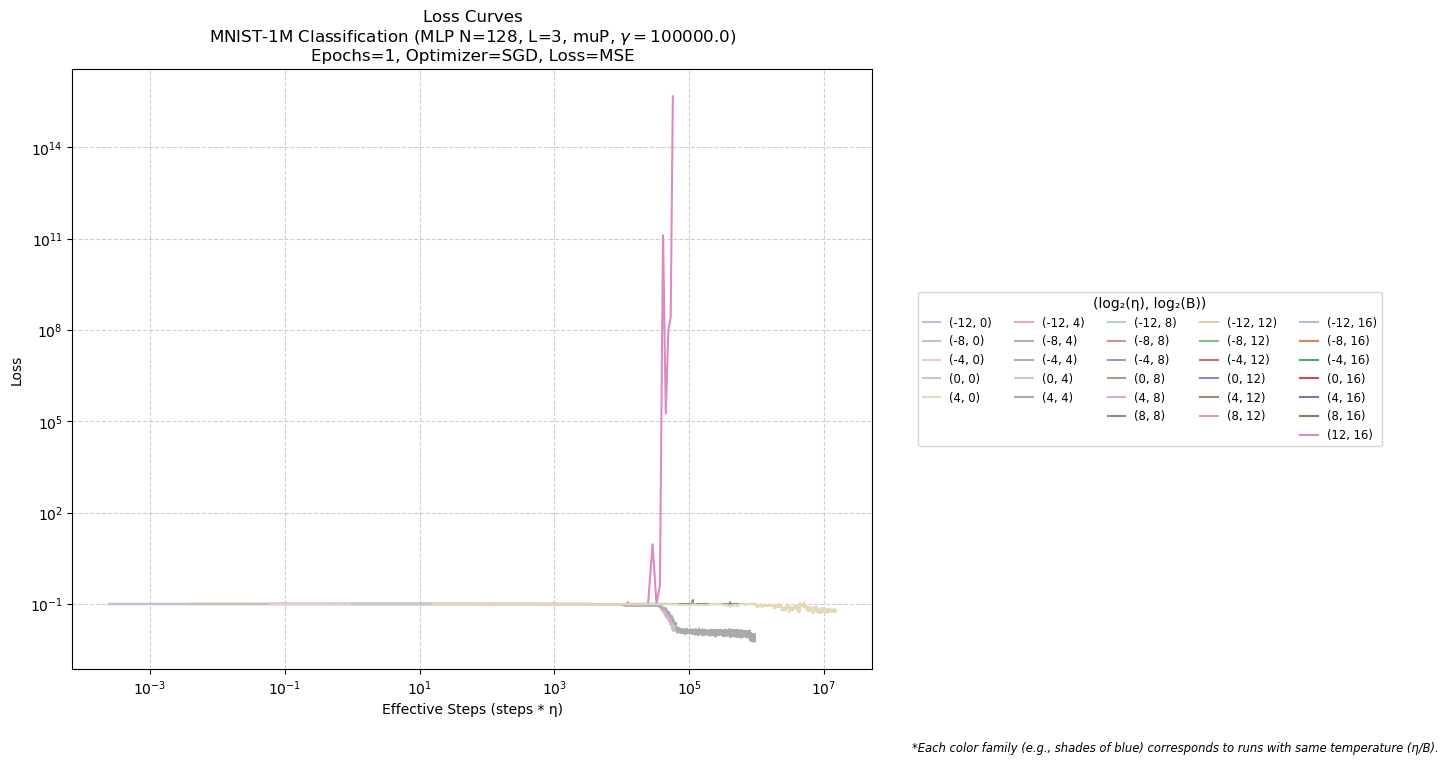

In [18]:
for gamma0 in experiments.keys():
    plot_all_loss_curves(
        sample_aware_smooth_loss_dicts(
            subsample_loss_dict_periodic(loss_dicts[gamma0], 'both', 4),
            rk_smoother
        ),
        title_exp=experiments[gamma0].plot_title(),
        plot_group_by="temp",
        use_eff_steps=True,
        x_scale="log",
    );   

# Exploratory questions

## For laziest network, is catapult affected by temperature or only by η?

We check if "if one, then all" behavior is noticed wherein if a network catapults for certain (b,η) with given temperature it catapults for all other pairs of that temp.

In [19]:
gamma0 = 'mnist1m_classification_mup_MSE_gamma1e-05'

In [20]:
losses, experiment = loss_dicts[gamma0], experiments[gamma0]

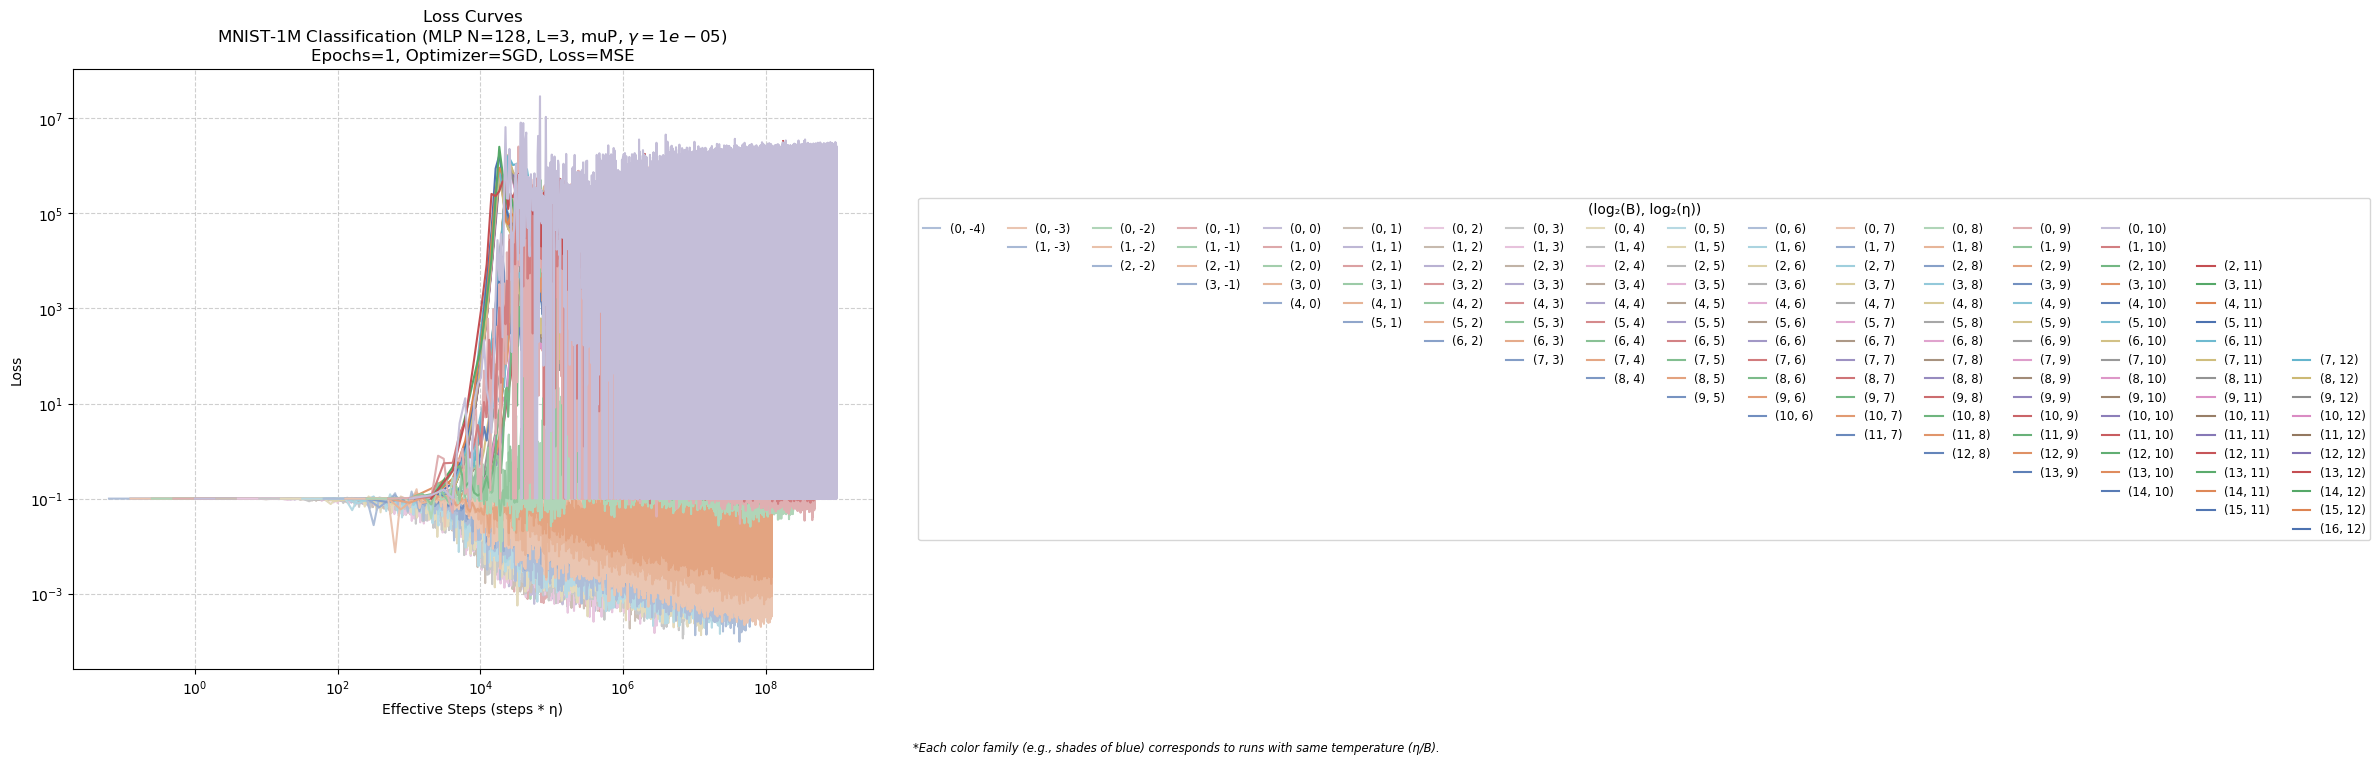

In [21]:
plot_all_loss_curves(
    filter_loss_dict_by_cutoff(losses, 'temp', 2 ** -4),
    title_exp=experiment.plot_title(),
    plot_group_by="temp",
    use_eff_steps=True,
    x_scale="log",
);   

In [22]:
catapult_cutoff = 2e1

In [23]:
catapult_candidates = {rk:v for rk,v in losses.items() if max(v['loss_history']) > catapult_cutoff}
catapulting_temps = set(rk.temp for rk in catapult_candidates.keys())

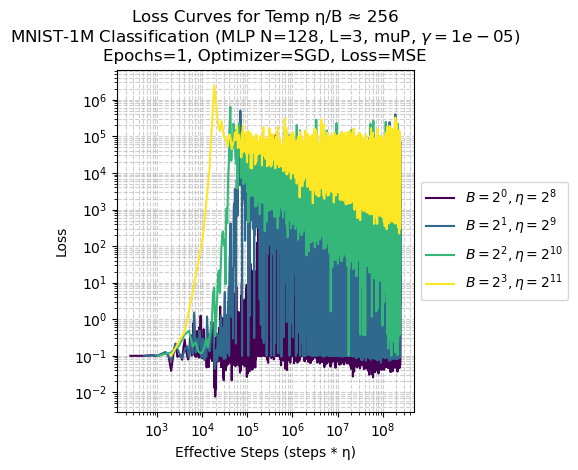

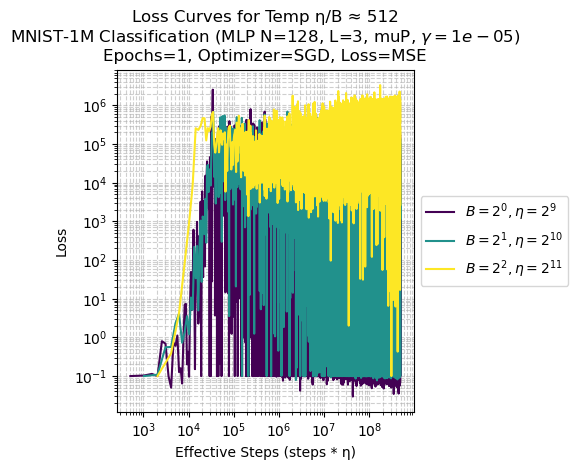

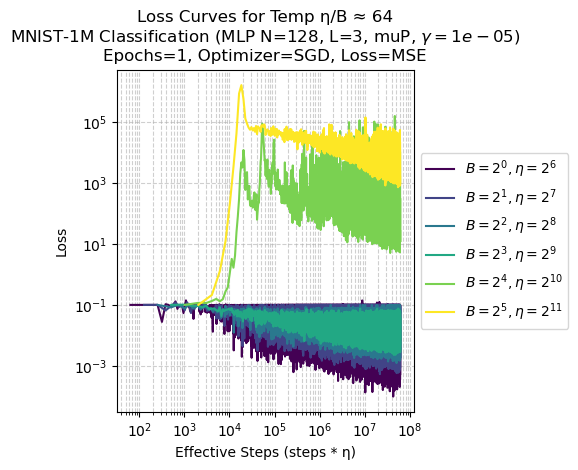

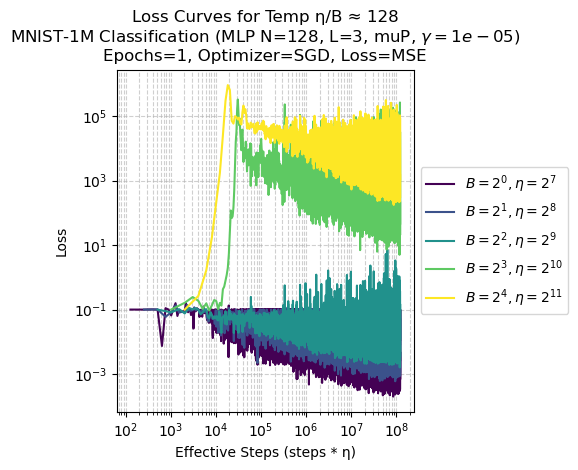

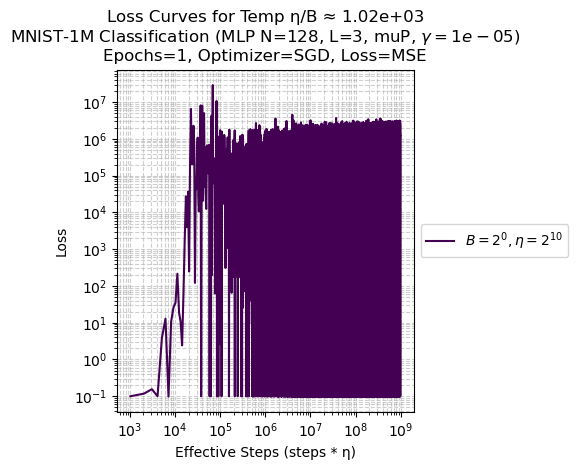

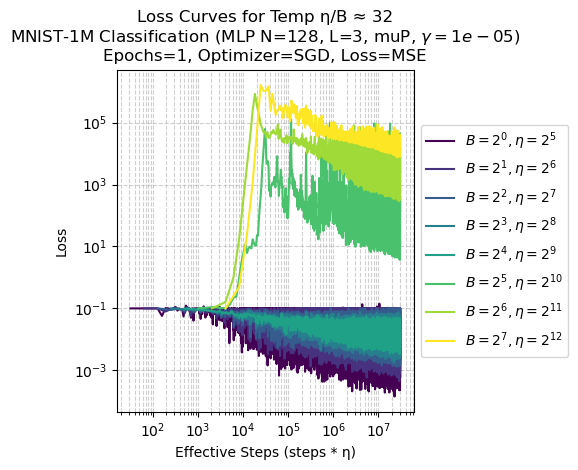

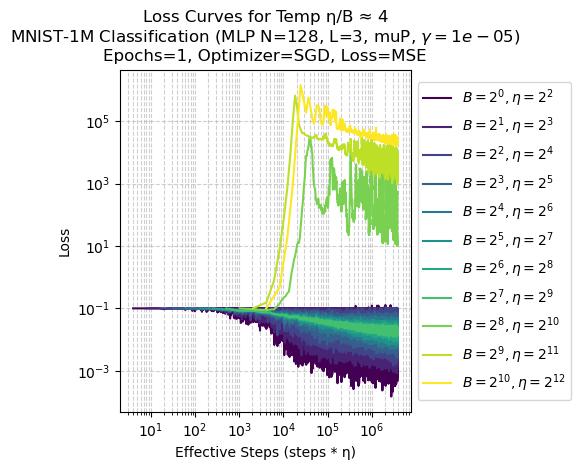

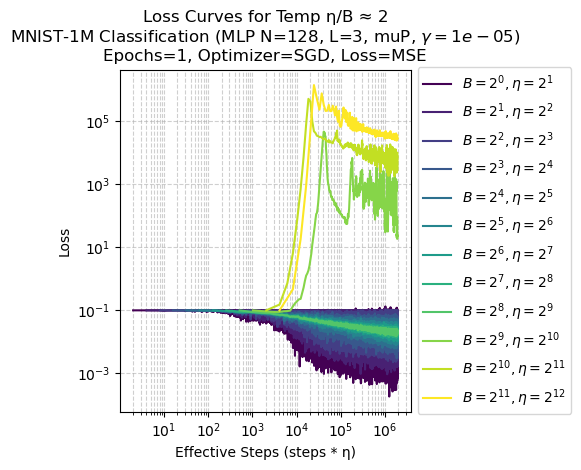

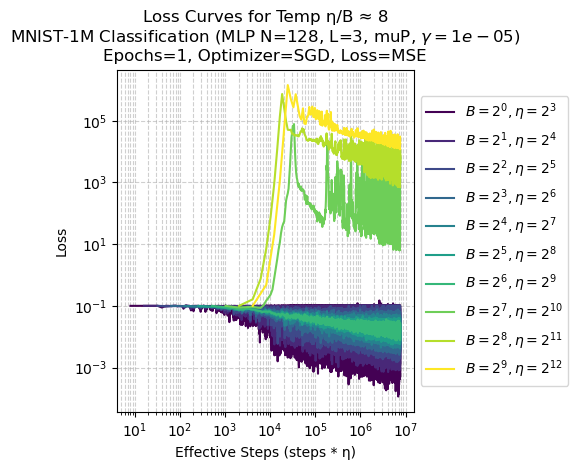

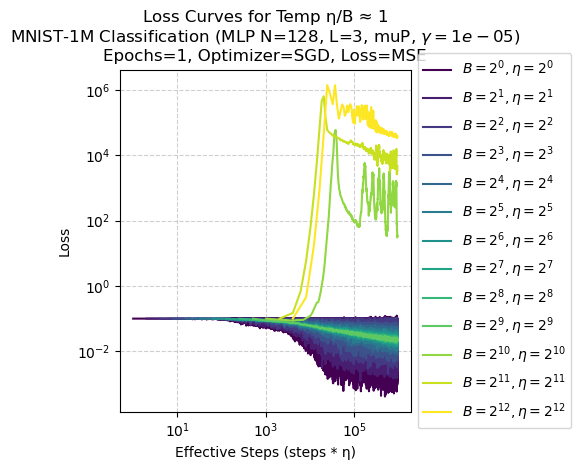

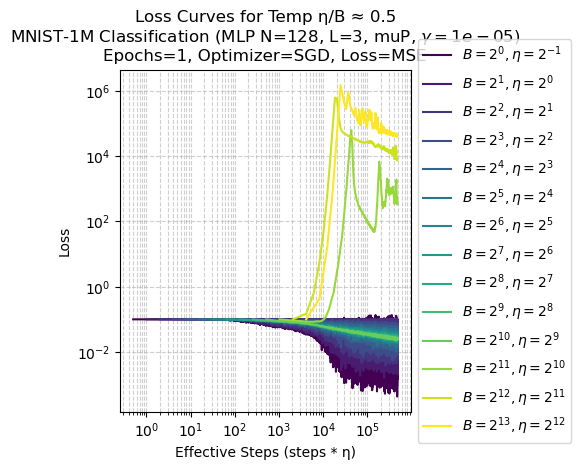

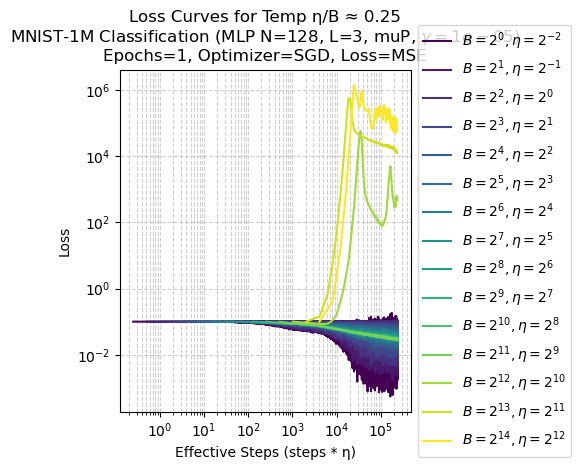

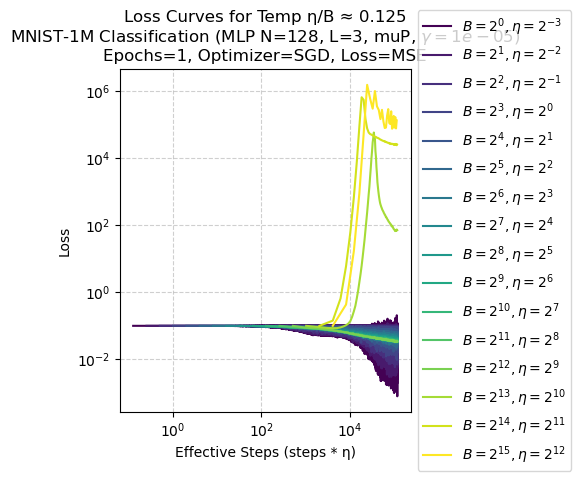

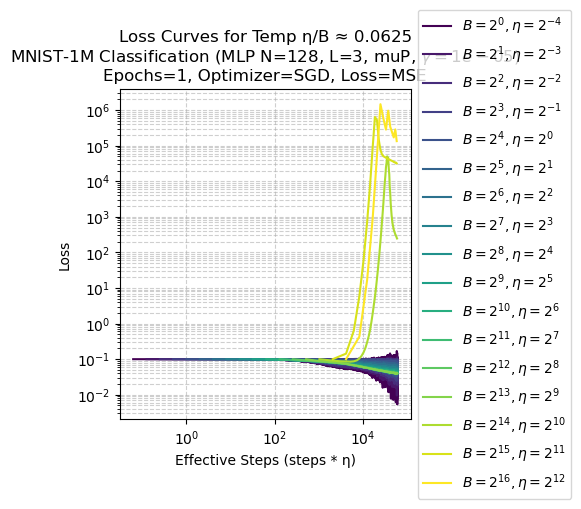

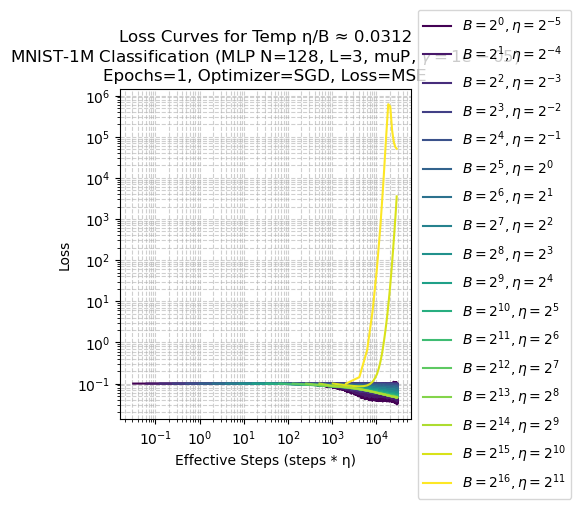

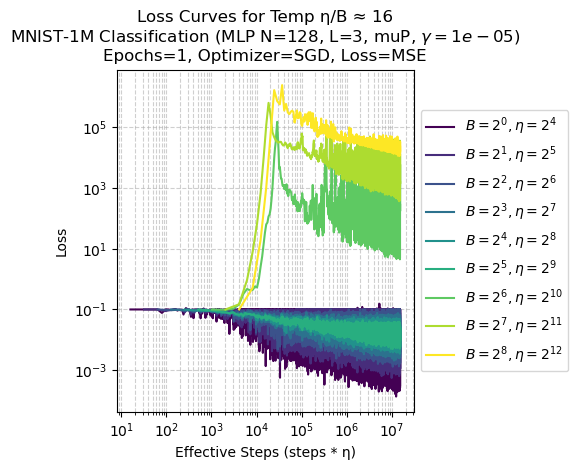

In [24]:
for temp in catapulting_temps:
    plot_loss_curves(
        losses,
        title_exp=experiment.plot_title(),
        group_by="temp",
        group_values=temp,
        use_eff_steps=True,
        x_scale="log",
        cmap='viridis'
    );  

## Q2: Quantifying noise


last_this_many_samples = 1e6

In [25]:
samples_for_noise = 1e5

In [26]:
from batch_size_studies.data_utils import extract_noise_loss_dicts

In [27]:
noise = extract_noise_loss_dicts(loss_dicts[gamma0], rk_smoother)

In [28]:
noise[RunKey(batch_size=1, eta=0.000244140625)].shape[0]

950000

In [29]:
clean_noise = defaultdict(np.ndarray)

for rk, n in noise.items():
    if n.shape[0] > samples_for_noise:
        clean_noise[rk] = n[-int(samples_for_noise):]

In [30]:
std_noise = {
    rk:v.var() for rk, v in clean_noise.items()
}

In [31]:
temp_noise = defaultdict(list[float])

for rk, std in std_noise.items():
    temp_noise[rk.temp].append(float(std))

In [33]:
noise = defaultdict(list)
for gamma0, loss_dict in loss_dicts.items():
    noise[gamma0] = extract_noise_loss_dicts(loss_dicts, rk_smoother)